In [1]:
image_path = 'data_pipes/data_test1/sample1.las'
image_save = 'data_pipes/data_test1/sample1.csv'

original dataset size (500000, 6)
Estimated number of clusters: 94
Estimated number of noise points: 503
[0]
pipe data points: 180137


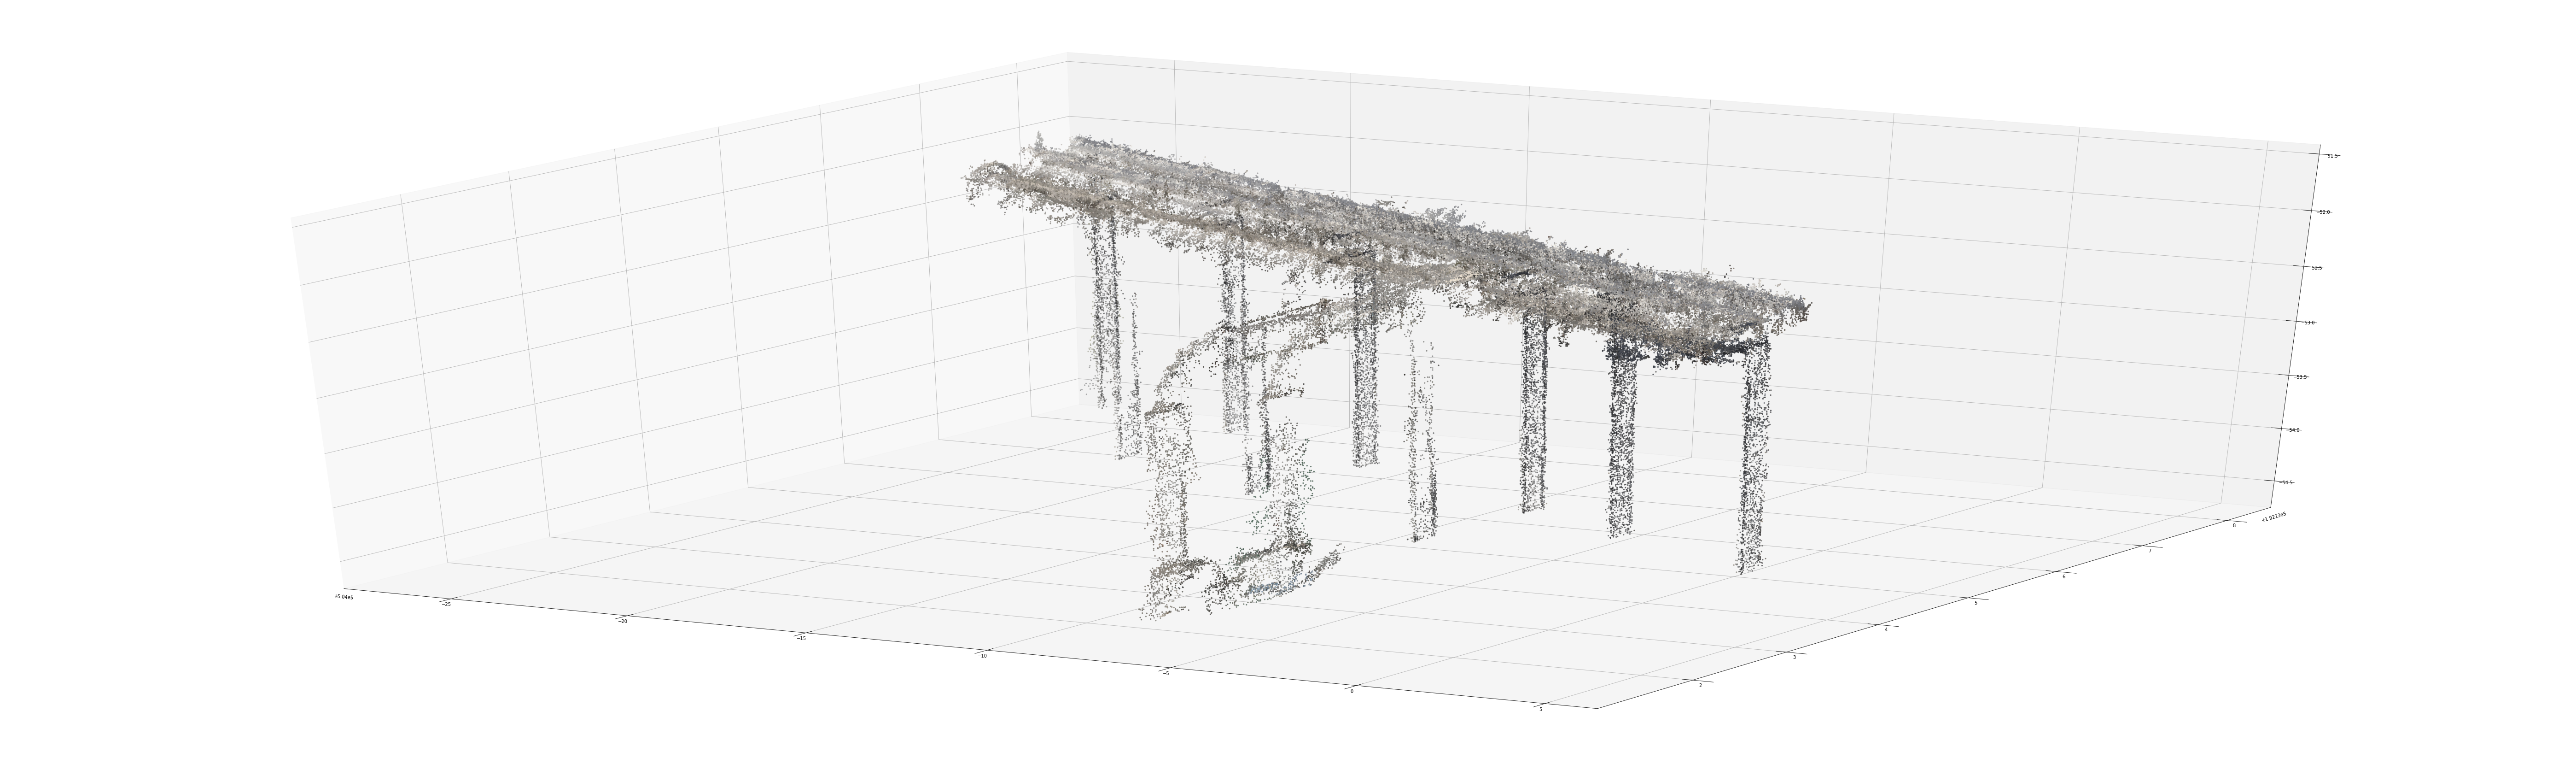

In [3]:
import laspy
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2
import warnings
import pandas as pd 
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import path


inFile = laspy.file.File(image_path)

dataset = np.vstack([inFile.x, inFile.y, inFile.z, inFile.red, inFile.green, inFile.blue]).transpose()
print('original dataset size', dataset.shape)

max1 = dataset[:,0].max()
min1 = dataset[:,0].min()

max2 = dataset[:,1].max()
min2 = dataset[:,1].min()

max3 = dataset[:,2].max()
min3 = dataset[:,2].min()

height = max3-min3

color = dataset[:,3:6]/65535
dataset1 = dataset[:,0:3]


# This is required for remove ground points

dataset2 = dataset1[dataset1[:,2] > min3 + 0.3 * height]
color2 = color[dataset1[:,2] > min3 + 0.3 * height]

dataset1 = dataset2
color = color2

# Do DBSCAN clustering

clustering = DBSCAN(eps=0.1, min_samples=5, leaf_size=10).fit(dataset1)

core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)
classfication = []
for k in unique_labels:
    class_member_mask = (labels == k)
    xyz = dataset1[class_member_mask & core_samples_mask]
    classfication.append(len(xyz))
    #print(len(xyz))

#print(classfication)
#print(max(classfication))


top_class = [classfication.index(x) for x in classfication if x>=0.1 * max(classfication)]
print(top_class)
top_number = len(top_class)


# OpenCV to compare image similarity

image_tot = [[0]]*len(top_class)
fig = [[0]]*len(top_class)

warnings.simplefilter("ignore", DeprecationWarning)

#for k, col in zip(unique_labels, colors):
for i in range(0,top_number):
    
    fig[i] = plt.figure(figsize=[20, 10])
    ax = fig[i].add_subplot(111)
    
    canvas = FigureCanvas(fig[i])
    
    k = top_class[i]
    class_member_mask = (labels == k)
    
    #print(k,class_member_mask)
    if k in top_class:
    #if k==4:
        xyz = dataset1[class_member_mask & core_samples_mask]
        
        XX = xyz[:,0]
        YY = xyz[:,1]
        ZZ = xyz[:,2]
        
        YY2D = YY
        
        ax.scatter(XX, YY2D, c='k', s=3)
        # Turn off tick labels
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.axis('off')
        
        plt.close()
        
        canvas.draw()     
        
        image = np.fromstring(fig[i].canvas.tostring_rgb(), dtype=np.uint8, sep='')
        image = image.reshape(fig[i].canvas.get_width_height()[::-1] + (3,))
        image_tot[i] = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
        

# to select the clustering indices which are pipelines

path_sample = 'pipe_images/pipe07.2.png'
img_sample = cv2.imread(path_sample, cv2.IMREAD_GRAYSCALE)


#pipe_index = []

score_max = 0.0
pipe_index = 0

for i in range(0,len(top_class)):
    
    img_compare = image_tot[i]
    
    orb = cv2.ORB_create()
    
    kp_a, desc_a = orb.detectAndCompute(img_sample, None)
    kp_b, desc_b = orb.detectAndCompute(img_compare, None)
    
    # initialize the bruteforce matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # match.distance is a float between {0:100} - lower means more similar
    matches = bf.match(desc_a, desc_b)
    similar_regions = [i for i in matches if i.distance < 35]
    if len(matches) == 0:
        print(0)
    score = len(similar_regions)/len(matches)
    #print(i,score)
    if (score > score_max) :
        pipe_index  = top_class[i]
        score_max = score
    
#print(pipe_index,score_max)


fig = plt.figure(figsize=[100, 30])
ax = fig.add_subplot(111, projection='3d')

colors = [plt.cm.Spectral(each)
  for each in np.linspace(0.3, 1, top_number)]

#print(colors)

for i,col in zip(range(0,top_number),colors):
    k = top_class[i]
    #print(k,col)
    class_member_mask = (labels == k)
    #col_pipe = color[class_member_mask & core_samples_mask]
    
    if k == pipe_index:
    #if k == 1:
        xyz = dataset1[class_member_mask & core_samples_mask]
        col_pipe = color[class_member_mask & core_samples_mask]
        print('pipe data points:', len(xyz))
        ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=col_pipe, marker=".")
        
        plt.show()

pipe_data = xyz

pipe_csv = np.concatenate((pipe_data, col_pipe * 255), axis=1)
pipe_csv.shape
pd.DataFrame(pipe_csv).to_csv(image_save)

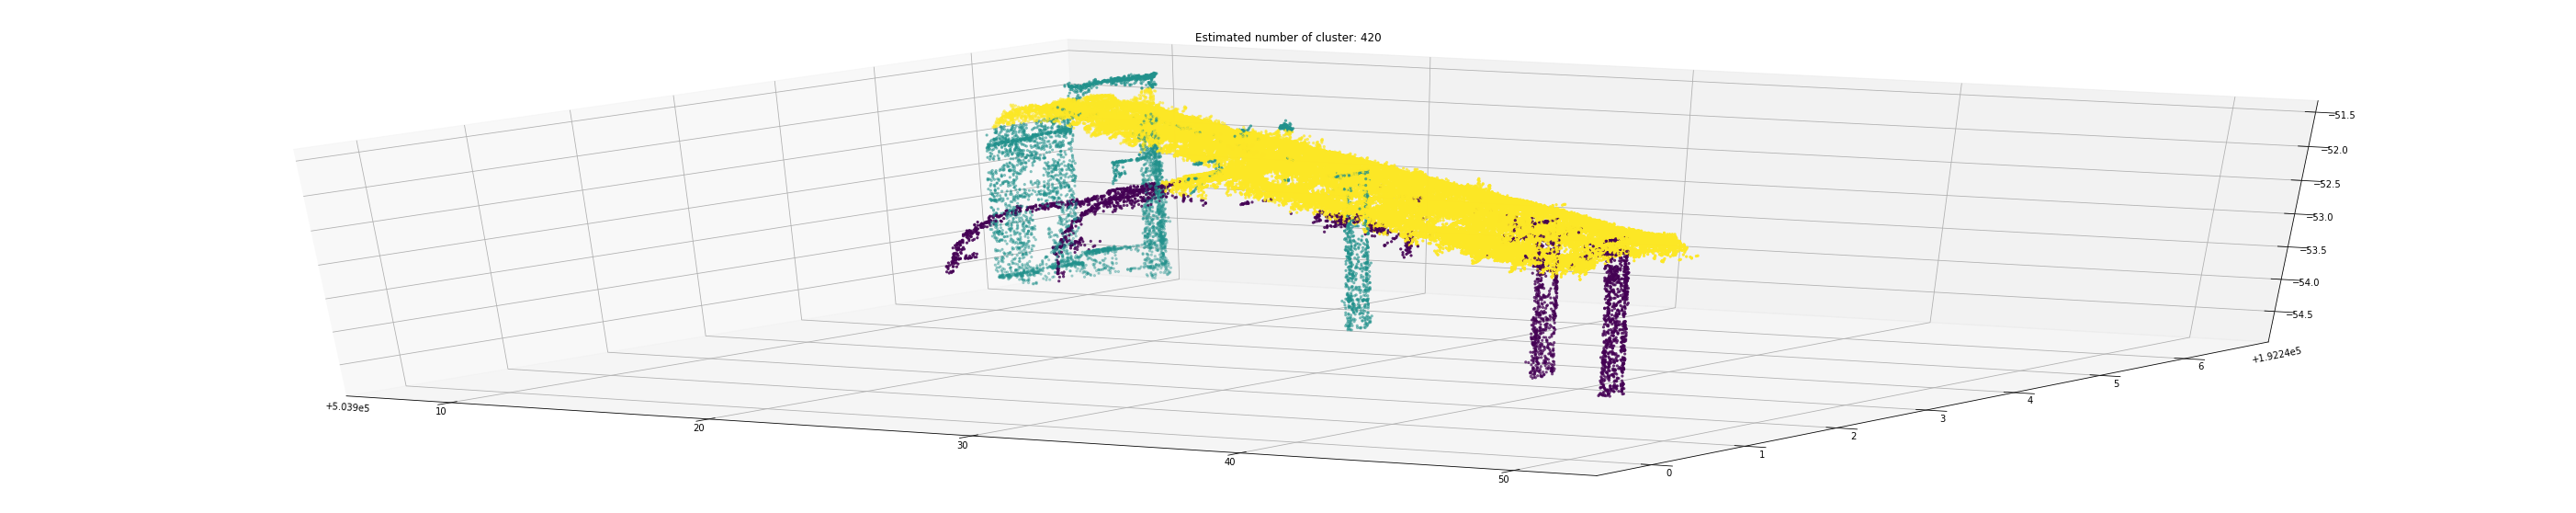

In [19]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3).fit(pipe_data).predict(pipe_data)

fig = plt.figure(figsize=[50, 10])
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pipe_data[:, 0], pipe_data[:, 1], pipe_data[:, 2], c=gmm, marker=".")

plt.title('Estimated number of cluster: %d' % n_clusters_)
plt.show()

In [50]:
import pandas as pd 

pipe_csv = np.concatenate((pipe_data, col_pipe * 255), axis=1)
pipe_csv.shape
pd.DataFrame(pipe_csv).to_csv(image_save)

In [59]:
pipe_data.shape
col_pipe.shape

(71813, 3)

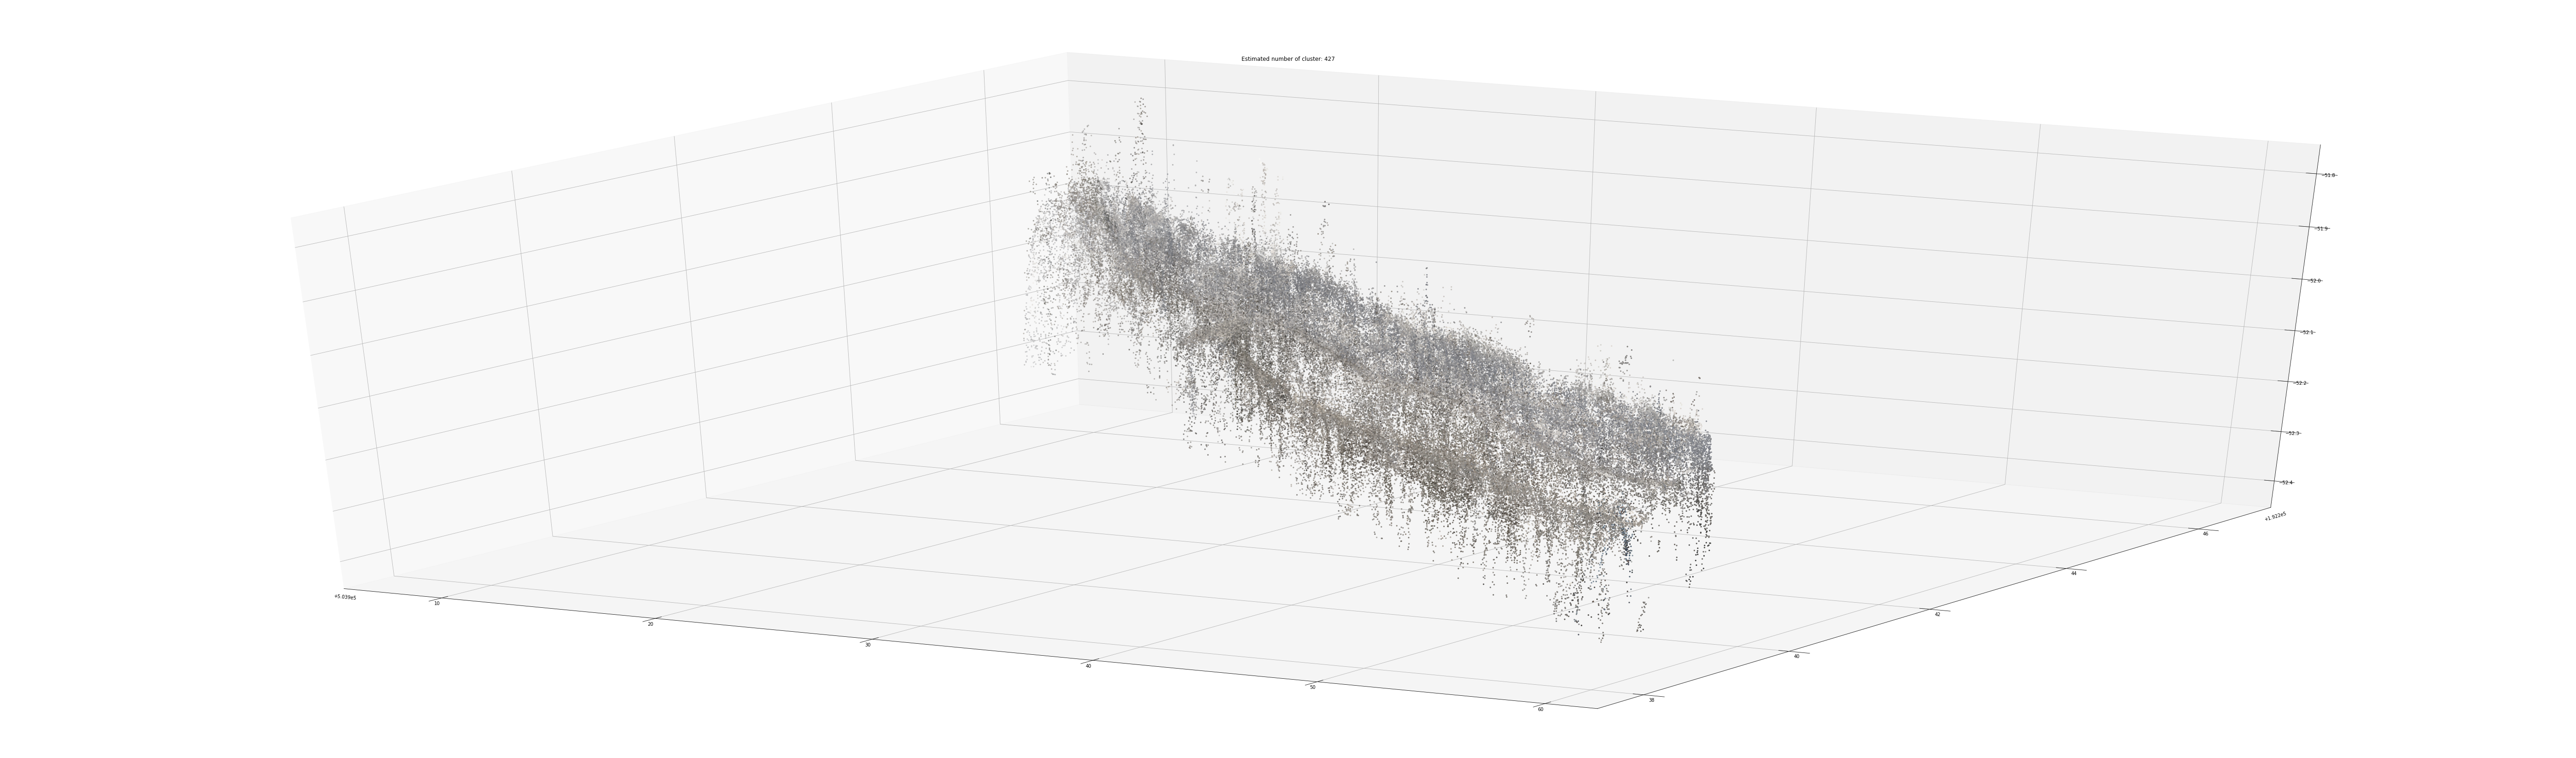

In [30]:
group1_index = np.where(gmm == 0)
group2_index = np.where(gmm == 1)

pipe_data1 = pipe_data[group1_index]
pipe_data2 = pipe_data[group2_index]

col_pipe1 = col_pipe[group1_index]
col_pipe2 = col_pipe[group2_index]

fig = plt.figure(figsize=[100, 30])
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pipe_data2[:, 0], pipe_data2[:, 1], pipe_data2[:, 2], c=col_pipe2, marker=".")

plt.title('Estimated number of cluster: %d' % n_clusters_)
plt.show()

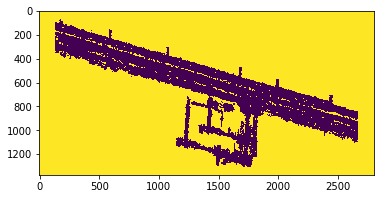

In [21]:
path_sample = 'pipe_images/pipe02.2.png'
img_sample = cv2.imread(path_sample, cv2.IMREAD_GRAYSCALE)

plt.imshow(img_sample)